I am going to build a Large Language model and yeah ..that's it

#1.EDA


In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.9.0+cpu
tiktoken version: 0.12.0


In [2]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [3]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [4]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

class TextdatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
        return len(self.input_ids)

  def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [5]:
 def __len__(self):
        return len(self.input_ids)

 def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


In [6]:

def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = TextdatasetV1atasetV1(txt, tokenizer, max_length, stride)


    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [7]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

vocab_size = 50257
output_dim = 256
context_length = 1024


token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")

    # Corrected typo here
    dataset = TextdatasetV1(txt, tokenizer, max_length, stride)


    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

batch_size = 8
max_length = 4
dataloader = create_dataloader_v1(
    raw_text,
    batch_size=batch_size,
    max_length=max_length,
    stride=max_length
)

In [8]:

 for batch in dataloader:
  x,y = batch

  token_embeddingd=token_embedding_layer(x)
  pos_embeddings=pos_embedding_layer(torch.arange(max_length))

  input_embeddings=token_embeddingd+pos_embeddings

  break

In [9]:
print(input_embeddings.shape)

torch.Size([8, 4, 256])


#1.Attention Mechanisms

multi head attention

In [10]:
import torch
import torch.nn as nn

class CausalSelfAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)

    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

  def forward(self, x):
    b, n_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    attn_scores = queries @ keys.transpose(1, 2)
    attn_scores.masked_fill_(self.mask[:n_tokens, :n_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_scores / (keys.shape[-1]**0.5), dim=-1)
    attn_weights = self.dropout(attn_weights)

    context_vec = attn_weights @ values
    return context_vec

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    self.num_heads = num_heads
    self.d_out = d_out
    self.heads = nn.ModuleList(
        [CausalSelfAttention(d_in, d_out, context_length, dropout, qkv_bias)
         for _ in range(num_heads)]
    )
    self.out_proj = nn.Linear(num_heads * d_out, d_out)

  def forward(self, x):

    context_vecs = torch.cat([head(x) for head in self.heads], dim=-1)

    return self.out_proj(context_vecs)

In [11]:
torch.manual_seed(123)

d_in = output_dim
d_out = output_dim
num_heads = 8
context_length = max_length
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads)

batch = input_embeddings
context_vecs = mha(batch)

print("context_vecs.shape:", context_vecs.shape)


context_vecs.shape: torch.Size([8, 4, 256])


Implementing the GPT text to generate words

In [12]:
import torch.nn as nn
import torch

class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)
    var=x.var(dim=-1,keepdim=True,unbiased=False)
    norm_x=(x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x+self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi))*
        (x+0.044715 * torch.pow(x,3))
    ))

In [13]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"])
    )

  def forward(self,x):
    return self.layers(x)

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att=MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"]
    )

    self.ff=FeedForward(cfg)
    self.norm1=LayerNorm(cfg["emb_dim"])
    self.norm2=LayerNorm(cfg["emb_dim"])
    self.drop_shortcut=nn.Dropout(cfg["drop_rate"])

  def forward(self,x):

    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut


    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

In [14]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

  def generate_text_Simple(self, idx, max_new_tokens, context_length):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -context_length:]

      with torch.no_grad():
        logits = self(idx_cond)


      logits = logits[:, -1, :]
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)
      idx = torch.cat((idx, idx_next), dim=-1)

    return idx

In [15]:
import tiktoken
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)
    var=x.var(dim=-1,keepdim=True,unbiased=False)
    norm_x=(x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x+self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi))*
        (x+0.044715 * torch.pow(x,3))
    ))

def main():
  GPT_CONFIG_124M={
    "vocab_size": 50257,
        "context_length": 1024,
        "emb_dim": 768,
        "n_heads": 12,
        "n_layers": 12,
        "drop_rate": 0.1,
        "qkv_bias": False
  }

  torch.manual_seed(123)
  model=GPTModel(GPT_CONFIG_124M)
  model.eval()

  start_context="Hello, I am"

  tokenizer=tiktoken.get_encoding("gpt2")
  encoded=tokenizer.encode(start_context)
  encoded_tensor=torch.tensor(encoded).unsqueeze(0)

  print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
  print("\nInput text:", start_context)
  print("Encoded input text:", encoded)
  print("encoded_tensor.shape:", encoded_tensor.shape)

  out=model.generate_text_Simple(
      idx=encoded_tensor,
      max_new_tokens=10,
      context_length=GPT_CONFIG_124M["context_length"]
  )

  decoded_text=tokenizer.decode(out.squeeze(0).tolist())
  print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
  print("\nOutput:", out)
  print("Output length:", len(out[0]))
  print("Output text:", decoded_text)


if __name__ == "__main__":
    main()


                      IN

Input text: Hello, I am
Encoded input text: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716,  1686, 17362, 37021,  6805, 33311, 40953,
         29515, 46248,  6723,  5409]])
Output length: 14
Output text: Hello, I amaps BaseballEdge components Keeping loosenetsksomeone SS decide


In [16]:
import matplotlib.pyplot as plt
import os
import requests
import torch
import tiktoken


In [27]:
from  llms_from_scratch.ch04 import GPTModel

In [28]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [45]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
       token_ids = generate_text_simple(
    model=model,  # Pass model as an argument
    idx=encoded,
    max_new_tokens=50,
    context_size=context_size
)
decoded_text = token_ids_to_text(token_ids, tokenizer)
print(decoded_text.replace("\n", " "))  # Compact print format
model.train()

Every effort moves you rentingetic wasnم refres RexMeCHicular stren


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [46]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    global_step = -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [47]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots()

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show() # Ensure plt.show() is called


def main(gpt_config, settings):

    torch.manual_seed(123)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    file_path = "the-verdict.txt"
    url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    # Model initialization
    model = GPTModel(gpt_config)
    model.to(device)

    # Optimizer setup
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
    )

    # Dataloader creation
    train_ratio = 0.90
    split_idx = int(train_ratio * len(text_data))

    train_loader = create_dataloader_v1(
        text_data[:split_idx],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0
    )

    val_loader = create_dataloader_v1(
        text_data[split_idx:],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0
    )

    tokenizer = tiktoken.get_encoding("gpt2")

    # Training loop call
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=settings["num_epochs"], eval_freq=5, eval_iter=1,
        start_context="Every effort moves you", tokenizer=tokenizer
    )

    return train_losses, val_losses, tokens_seen, model

In [48]:
model = GPTModel(gpt_config)
model.to(device)
optimizer = torch.optim.AdamW(
model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
    )

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

train_loader = create_dataloader_v1(
        text_data[:split_idx],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0
    )

val_loader = create_dataloader_v1(
        text_data[split_idx:],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0
    )



Ep 1 (Step 000000): Train loss 9.812, Val loss 9.846
Ep 1 (Step 000005): Train loss 7.588, Val loss 8.044
Ep 2 (Step 000010): Train loss 6.582, Val loss 6.800
Ep 2 (Step 000015): Train loss 5.920, Val loss 6.592
Ep 3 (Step 000020): Train loss 15.767, Val loss 16.154
Ep 3 (Step 000025): Train loss 5.494, Val loss 6.384
Ep 4 (Step 000030): Train loss 4.373, Val loss 6.328
Ep 4 (Step 000035): Train loss 2.824, Val loss 6.258
Ep 5 (Step 000040): Train loss 3.969, Val loss 6.221
Ep 6 (Step 000045): Train loss 2.638, Val loss 6.221
Ep 6 (Step 000050): Train loss 3.156, Val loss 6.194
Ep 7 (Step 000055): Train loss 2.676, Val loss 6.162
Ep 7 (Step 000060): Train loss 1.728, Val loss 6.274
Ep 8 (Step 000065): Train loss 0.933, Val loss 6.259
Ep 8 (Step 000070): Train loss 1.371, Val loss 6.272
Ep 9 (Step 000075): Train loss 0.762, Val loss 6.329
Ep 9 (Step 000080): Train loss 0.563, Val loss 6.462
Ep 10 (Step 000085): Train loss 0.358, Val loss 6.542


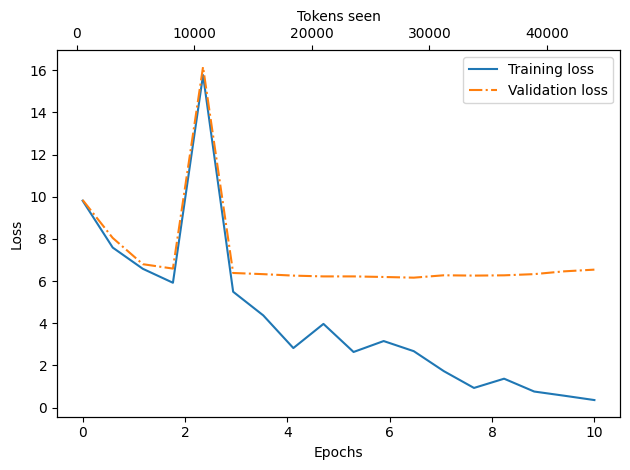

<Figure size 640x480 with 0 Axes>

In [49]:
tokenizer = tiktoken.get_encoding("gpt2")


if __name__ == "__main__":

    GPT_CONFIG_124M = {
        "vocab_size": 50257,
        "context_length": 256,
        "emb_dim": 768,
        "n_heads": 12,
        "n_layers": 12,
        "drop_rate": 0.1,
        "qkv_bias": False
    }

    OTHER_SETTINGS = {
        "learning_rate": 5e-4,
        "num_epochs": 10,
        "batch_size": 2,
        "weight_decay": 0.1
    }



    train_losses, val_losses, tokens_seen, model = main(GPT_CONFIG_124M, OTHER_SETTINGS)



    # Plot results
    epochs_tensor = torch.linspace(0, OTHER_SETTINGS["num_epochs"], len(train_losses))
    plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
    plt.savefig("loss.pdf")

    # Save and load model
    torch.save(model.state_dict(), "model.pth")
    model = GPTModel(GPT_CONFIG_124M)
    model.load_state_dict(torch.load("model.pth", weights_only=True))
